# Open-EO Proof Of Concept: Compositing
This notebook explains and demonstrates the OpenEO client API, as well as some concepts of the core API.

The OpenEO client API is distributed as a lightweight Python module. The dependencies of this module are limited to a set of well known modules such as numpy and pandas. This should allow it to run in different environments, and as part of larger workflows.
To get started, we import OpenEO, and set up standard Python logging.

In [12]:
import openeo
import logging
logging.basicConfig(level=logging.DEBUG)

To connect with an OpenEO backend, we create a session. Each OpenEO backend has a different endpoint, metadata and credentials. A session object contains this information, and is the starting point for subsequent calls. 

In [2]:
session = openeo.session("nobody", "http://openeo.vgt.vito.be")

Our first use case is to create a composite image by taking the maximum pixel value over a timeseries of images.
To do this, we first need to select input data. Each OpenEO endpoint exposes it's own list of image collections.
For instance: http://openeo.vgt.vito.be/openeo/data

Preferably, these layers and their descriptions and metadata can be browsed online, so a user can discover data that suits his needs.

In this example, the collection id is 'S2_FAPAR_V101', which corresponds to the fAPAR biophysical parameter at 10M resolution over Belgium, derived from Sentinel 2 data.

In the client code, the user can create an image collection quite easily. This is just an empty object on which further operations need to be defined:

In [19]:
s2_fapar = session.imagecollection("S2_FAPAR_V101")
s2_fapar

As the image collection can be quite large, a first step is usually to define a spatial and temporal subset on which we want to operate. This can be done by specifying a date range and a bounding box:

In [20]:
timeseries = s2_fapar\
.date_range_filter("2017-04-01","2017-09-10")\
.bbox_filter(left=4.3,right=5.0,top=50.55,bottom=50.28,srs="EPSG:4326")
timeseries

Now we're all set to compute the composite, the max_time function allows us to specify the function that needs to be applied, but does not yet compute a result:

In [24]:
%time composite = timeseries.max_time()
composite

CPU times: user 20 µs, sys: 24 µs, total: 44 µs
Wall time: 53.9 µs


Up to this point, the OpenEO backend has not yet received a request for computation. We have only specified what is called a 'process graph' in OpenEO terms.
We can do a few things with a process graph, let's start with downloading its result as a GeoTiff:

In [25]:
%time composite.download("./openeo-composite.geotiff","geotiff")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): openeo.vgt.vito.be
DEBUG:urllib3.connectionpool:http://openeo.vgt.vito.be:80 "POST /openeo/execute HTTP/1.1" 200 23605637


CPU times: user 364 ms, sys: 233 ms, total: 598 ms
Wall time: 48.1 s


The debug logging shows us that this call has sent our 'process graph' to: /openeo/execute. This particular composite took only 48 seconds to compute over a timeseries of about 5 months worth of input data. 

This shows one of the key points of OpenEO: the algorithm gets distributed over processing resources close to the data, which can greatly speed up processing.

Now it's time to inspect our result. One way is to use gdalinfo:

In [26]:
!ls -lh openeo-composite.*
!rm openeo-composite.geotiff.aux.xml
!gdalinfo -hist openeo-composite.geotiff

-rw-r--r--. 1 driesj driesj 23M Mar  2 20:30 openeo-composite.geotiff
-rw-r--r--. 1 driesj driesj 878 Mar  2 15:50 openeo-composite.geotiff.aux.xml
Driver: GTiff/GeoTIFF
Files: openeo-composite.geotiff
Size is 7680, 3072
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (4.298130412513061,50.558600934228501)
Pixel Size = (0.000097215289858,-0.000097215289858)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (   4.2981304,  50.5586009) (  4d17'53.27"E, 50d33'30.96"N)
Lower Left  (   4.2981304,  50.2599556) (  4d17'53.27"E, 50d15'35.84"N)
Upper Right (   5.0447438,  50.5586009) (  5d 2'41.08"E, 50d33'30.96"N)
Lower Right (   5.0447438,  50.2599556) (  5d 2'41.08"E, 50d15'35.84"N)
Center      (   

## Retrieving a timeseries for a point
Instead of reducing our timeseries of images into a composite, we can also request each value for a given geographical coordinate. 

This call can be executed directly on the timeseries that we defined earlier:

In [28]:
%time point_timeseries = timeseries.timeseries(4.4,50.30,srs="EPSG:4326")
point_timeseries.json()

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): openeo.vgt.vito.be
DEBUG:urllib3.connectionpool:http://openeo.vgt.vito.be:80 "POST /openeo/timeseries/point?x=4.4&y=50.3&srs=EPSG:4326 HTTP/1.1" 200 3133


CPU times: user 15.9 ms, sys: 7.92 ms, total: 23.9 ms
Wall time: 40.2 s


{'2017-04-03T00:00:00+00:00': [106.0],
 '2017-04-06T00:00:00+00:00': [nan],
 '2017-04-09T00:00:00+00:00': [nan],
 '2017-04-16T00:00:00+00:00': [nan],
 '2017-04-19T00:00:00+00:00': [nan],
 '2017-04-23T00:00:00+00:00': [nan],
 '2017-04-26T00:00:00+00:00': [nan],
 '2017-04-29T00:00:00+00:00': [nan],
 '2017-05-03T00:00:00+00:00': [nan],
 '2017-05-06T00:00:00+00:00': [131.0],
 '2017-05-09T00:00:00+00:00': [nan],
 '2017-05-13T00:00:00+00:00': [112.0],
 '2017-05-16T00:00:00+00:00': [48.0],
 '2017-05-19T00:00:00+00:00': [nan],
 '2017-05-23T00:00:00+00:00': [nan],
 '2017-05-26T00:00:00+00:00': [175.0],
 '2017-05-29T00:00:00+00:00': [nan],
 '2017-06-02T00:00:00+00:00': [63.0],
 '2017-06-05T00:00:00+00:00': [158.0],
 '2017-06-12T00:00:00+00:00': [nan],
 '2017-06-15T00:00:00+00:00': [87.0],
 '2017-06-18T00:00:00+00:00': [nan],
 '2017-06-22T00:00:00+00:00': [82.0],
 '2017-06-25T00:00:00+00:00': [nan],
 '2017-06-28T00:00:00+00:00': [nan],
 '2017-06-30T00:00:00+00:00': [nan],
 '2017-07-02T00:00:00+00

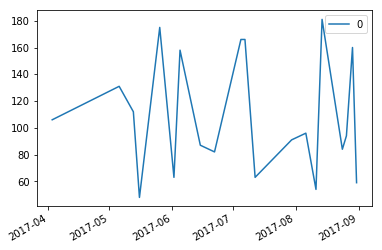

In [8]:
import pandas as pd
series_df = pd.DataFrame.from_dict(timeseries.json(), orient="index")
series_df.index = pd.to_datetime(series_df.index)
import seaborn as sns
%matplotlib inline
series_df.dropna().plot()


In [9]:
series_df.dropna()

,0
2017-06-02,63.0
2017-05-16,48.0
2017-05-13,112.0
2017-06-22,82.0
2017-06-15,87.0
2017-08-11,54.0
2017-07-30,91.0
2017-07-12,63.0
2017-08-31,59.0
2017-05-06,131.0


## Showing the result
Using rasterio, we can load and plot our downloaded file.

In [10]:
import rasterio
%matplotlib inline

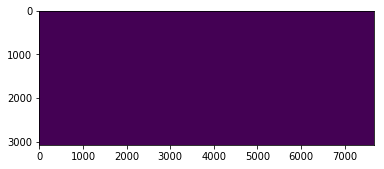

In [11]:
from rasterio.plot import show
from matplotlib import pyplot
composite_local = rasterio.open("./openeo-composite.geotiff")
#fig, ax = pyplot.subplots(1, figsize=(20, 6))
show(composite_local.read(1))
composite_local.close()
#pyplot.show()